## Core Imports

In [2]:
import torch
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import pytorch_lightning as pl


print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("MediaPipe Version:", mp.__version__)
print("OpenCV Version:", cv2.__version__)
print("PyTorch Lightning Version:", pl.__version__)

PyTorch Version: 2.5.1+cu124
CUDA Available: False
MediaPipe Version: 0.10.18
OpenCV Version: 4.10.0
PyTorch Lightning Version: 2.4.0


### Other imports (Tools and Libraries)

In [86]:
import json
import os
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset,Subset
import kagglehub
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
#path = kagglehub.dataset_download("prathumarikeri/american-sign-language-09az")
#print("Path to dataset files:", path)

100%|██████████| 993M/993M [05:06<00:00, 3.39MB/s] 

Extracting files...


Path to dataset files: /home/rufevean/.cache/kagglehub/datasets/prathumarikeri/american-sign-language-09az/versions/1


In [83]:
# root_dir = 'data'
# labels = os.listdir(root_dir)
# labels.sort()
# print("Labels:", labels)
# image_counts = {label: len(os.listdir(os.path.join(root_dir, label))) for label in labels}
# print("Image Counts:", image_counts)
# plt.figure(figsize=(12, 6))
# plt.bar(image_counts.keys(), image_counts.values())
# plt.xlabel('Sign Language Alphabet (A-Z)')
# plt.ylabel('Number of Images')
# plt.title('Distribution of Images per Sign Language Alphabet Letter')
# plt.xticks(rotation=90)
# plt.show()
# target_size = (224, 224)
# def check_image_quality(root_dir,labels):
#     corrupted_images = []
#     image_sizes = {}

#     for label in labels:
#         label_dir = os.path.join(root_dir, label)
#         if os.path.isdir(label_dir):
#             for image_name in os.listdir(label_dir):
#                 image_path = os.path.join(label_dir, image_name)
#                 try:
#                     image = Image.open(image_path)
#                     image_sizes[image_path] = image.size
#                 except:
#                     corrupted_images.append(image_path)
#     return image_sizes,corrupted_images
# print(f"Total number of corrupted images: {len(corrupted_images)}")
# if corrupted_images:
#     print("Corrupted image paths:", corrupted_images)
# resolutions = set(image_sizes.values())
# print(f"Unique image resolutions: {resolutions}")
# image_sizes,corrupted_images = check_image_quality(root_dir,labels)
# for label in os.listdir(root_dir):
#     label_dir = os.path.join(root_dir, label)
#     if os.path.isdir(label_dir):
#         for image_name in os.listdir(label_dir):
#             image_path = os.path.join(label_dir, image_name)
#             image = Image.open(image_path)
#             image = image.resize(target_size)
#             image.save(image_path) 
# transform = transforms.Compose([
#     transforms.Resize(target_size),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
# image_sizes_suf,corrupted_images_suf= check_image_quality(root_dir, labels)
# resolutions = set(image_sizes_suf.values())
# print(f"Unique image resolutions: {resolutions}")

## Dataset building and preprocessing

In [ ]:

data_root = 'data'  
class CustomSignLanguageDataset(Dataset):
    def __init__(self, data_root, transform=None):
        self.data_root = data_root
        self.transform = transform
        
        self.image_paths = []
        self.labels = []
        
        for label, letter in enumerate(os.listdir(data_root)):
            class_dir = os.path.join(data_root, letter)
            if os.path.isdir(class_dir):
           
                for filename in os.listdir(class_dir):
                    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'): 
                        image_path = os.path.join(class_dir, filename)
                        self.image_paths.append(image_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
    
        if self.transform:
            image = self.transform(image)
        
        return image, label


transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

dataset = CustomSignLanguageDataset(data_root, transform=transform)

image, label = dataset[0]
print(f"Image shape: {image.shape}, Label: {label}")


Image shape: torch.Size([3, 224, 224]), Label: 0


### Data visualization

In [72]:

print(f"Total images in dataset: {len(dataset)}")

unique_labels = set(dataset.labels)
print(f"Unique labels (classes): {unique_labels}")


Total images in dataset: 142261
Unique labels (classes): {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..1.8892884].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9131652..2.0648367].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..1.3328106].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..1.8033988].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.060536].


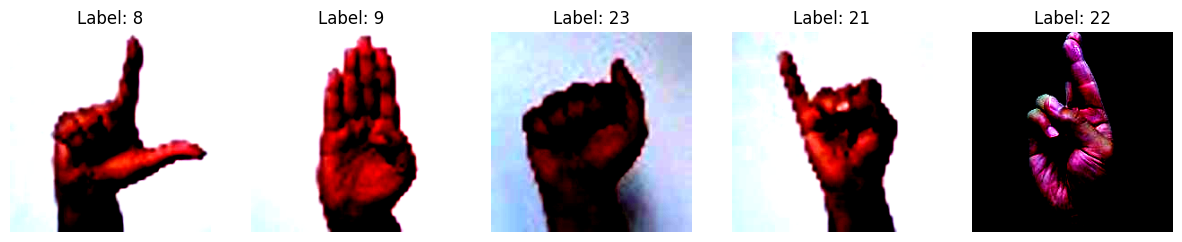

In [80]:

def imshow(image):
    image = image.permute(1, 2, 0).numpy() 
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) 
    image = np.clip(image, 0, 1)  
    plt.imshow(image)
    plt.axis('off')

def show_sample_images_from_different_labels(dataset, num_samples=5):
    unique_labels = list(set(dataset.labels)) 
    sampled_labels = np.random.choice(unique_labels, num_samples, replace=False)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, label in enumerate(sampled_labels):
        idx = dataset.labels.index(label)  
        image, label = dataset[idx]  
        axes[i].imshow(image.permute(1, 2, 0).numpy())
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")
    
    plt.show()

show_sample_images_from_different_labels(dataset, num_samples=5)



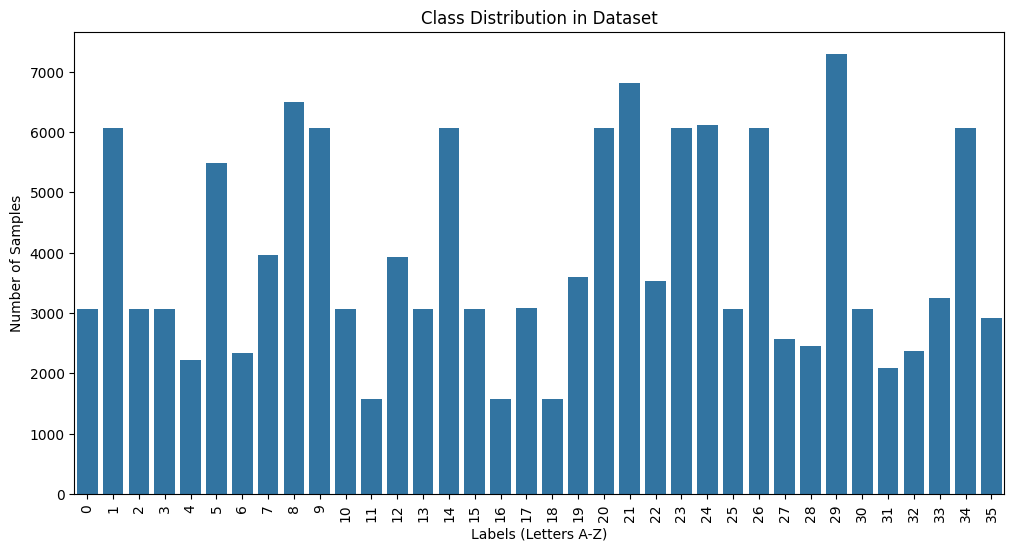

In [82]:

def plot_class_distribution(dataset):
    label_counts = {label: dataset.labels.count(label) for label in set(dataset.labels)}
    sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    labels, counts = zip(*sorted_labels)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(labels), y=list(counts))
    plt.title("Class Distribution in Dataset")
    plt.xlabel("Labels (Letters A-Z)")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=90)  
    plt.show()
plot_class_distribution(dataset)


### Splitting the dataset into training, testing and validation sets

In [88]:

image_paths = dataset.image_paths
labels = dataset.labels
train_images, test_images, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.3, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

train_dataset = CustomSignLanguageDataset(data_root, transform=transform)
val_dataset = CustomSignLanguageDataset(data_root, transform=transform)
test_dataset = CustomSignLanguageDataset(data_root, transform=transform)


train_dataset.image_paths = train_images
train_dataset.labels = train_labels

val_dataset.image_paths = val_images
val_dataset.labels = val_labels

test_dataset.image_paths = test_images
test_dataset.labels = test_labels

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")


Training set size: 99582
Validation set size: 21339
Test set size: 21340
